In [1]:
import kagglehub
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantdisease


In [2]:
!mkdir "PlantVillage"
!cp -r "/kaggle/input/plantdisease/PlantVillage" "/content/PlantVillage"
#!cp -r "/kaggle/input/plant-village/PlantVillage/Pepper__bell___healthy/" "/content/PlantVillage"

In [13]:
# Install required packages
!pip install transformers datasets torch torchvision scikit-learn matplotlib seaborn

# Import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import random

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [14]:
# Data directories - adjust this to your dataset location
data_dir = "/content/PlantVillage/PlantVillage"  # Change to your dataset path

# Data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Get class names
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Total dataset size: {len(full_dataset)}")

# Split dataset into train, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Create indices for the splits
indices = list(range(len(full_dataset)))
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Apply appropriate transforms to validation and test datasets
# We need to create new datasets with the correct transforms
val_dataset_transformed = datasets.ImageFolder(root=data_dir, transform=val_test_transform)
val_dataset = Subset(val_dataset_transformed, val_indices)

test_dataset_transformed = datasets.ImageFolder(root=data_dir, transform=val_test_transform)
test_dataset = Subset(test_dataset_transformed, test_indices)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Number of classes: 15
Total dataset size: 20638
Train dataset size: 14446
Validation dataset size: 3095
Test dataset size: 3097


In [15]:
# Define the Vision Transformer model
class PlantDiseaseViT(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseViT, self).__init__()
        # Load pre-trained ViT model
        self.vit = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

    def forward(self, x):
        outputs = self.vit(x)
        return outputs.logits

# Initialize model
model = PlantDiseaseViT(num_classes=num_classes).to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    test_loss = running_loss / len(data_loader.dataset)
    test_acc = np.mean(np.array(all_preds) == np.array(all_labels))

    # New: Calculate precision, recall, f1
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return test_loss, test_acc, report, conf_matrix, all_preds, all_labels, precision, recall, f1


Epoch 1/10 [Valid]: 100%|██████████| 97/97 [00:33<00:00,  2.88it/s, loss=0.1237, acc=97.61%]


Saved best model with validation accuracy: 0.9761
Epoch 1/10:
Train Loss: 0.0904, Train Acc: 0.9717
Val Loss: 0.0660, Val Acc: 0.9761
------------------------------------------------------------


Epoch 2/10 [Valid]: 100%|██████████| 97/97 [00:33<00:00,  2.88it/s, loss=0.0064, acc=99.19%]


Saved best model with validation accuracy: 0.9919
Epoch 2/10:
Train Loss: 0.0539, Train Acc: 0.9830
Val Loss: 0.0254, Val Acc: 0.9919
------------------------------------------------------------


Epoch 3/10 [Valid]: 100%|██████████| 97/97 [00:33<00:00,  2.88it/s, loss=0.0284, acc=99.19%]


Epoch 3/10:
Train Loss: 0.0359, Train Acc: 0.9882
Val Loss: 0.0290, Val Acc: 0.9919
------------------------------------------------------------


Epoch 4/10 [Valid]: 100%|██████████| 97/97 [00:33<00:00,  2.88it/s, loss=0.0033, acc=98.84%]


Epoch 4/10:
Train Loss: 0.0291, Train Acc: 0.9904
Val Loss: 0.0324, Val Acc: 0.9884
------------------------------------------------------------


Epoch 5/10 [Valid]: 100%|██████████| 97/97 [00:33<00:00,  2.87it/s, loss=0.0101, acc=99.48%]


Saved best model with validation accuracy: 0.9948
Epoch 5/10:
Train Loss: 0.0218, Train Acc: 0.9934
Val Loss: 0.0141, Val Acc: 0.9948
------------------------------------------------------------


Epoch 6/10 [Valid]: 100%|██████████| 97/97 [00:33<00:00,  2.87it/s, loss=0.0008, acc=98.80%]


Epoch 6/10:
Train Loss: 0.0259, Train Acc: 0.9922
Val Loss: 0.0307, Val Acc: 0.9880
------------------------------------------------------------


Epoch 7/10 [Valid]: 100%|██████████| 97/97 [00:33<00:00,  2.87it/s, loss=0.0568, acc=99.35%]


Epoch 7/10:
Train Loss: 0.0278, Train Acc: 0.9907
Val Loss: 0.0202, Val Acc: 0.9935
------------------------------------------------------------


Epoch 8/10 [Valid]: 100%|██████████| 97/97 [00:33<00:00,  2.88it/s, loss=0.0396, acc=97.38%]


Epoch 8/10:
Train Loss: 0.0226, Train Acc: 0.9916
Val Loss: 0.1022, Val Acc: 0.9738
------------------------------------------------------------


Epoch 9/10 [Valid]: 100%|██████████| 97/97 [00:33<00:00,  2.87it/s, loss=0.0143, acc=99.42%]


Epoch 9/10:
Train Loss: 0.0187, Train Acc: 0.9941
Val Loss: 0.0166, Val Acc: 0.9942
------------------------------------------------------------


Epoch 10/10 [Valid]: 100%|██████████| 97/97 [00:33<00:00,  2.88it/s, loss=0.0032, acc=99.81%]


Saved best model with validation accuracy: 0.9981
Epoch 10/10:
Train Loss: 0.0035, Train Acc: 0.9993
Val Loss: 0.0055, Val Acc: 0.9981
------------------------------------------------------------
Best validation accuracy: 0.9981


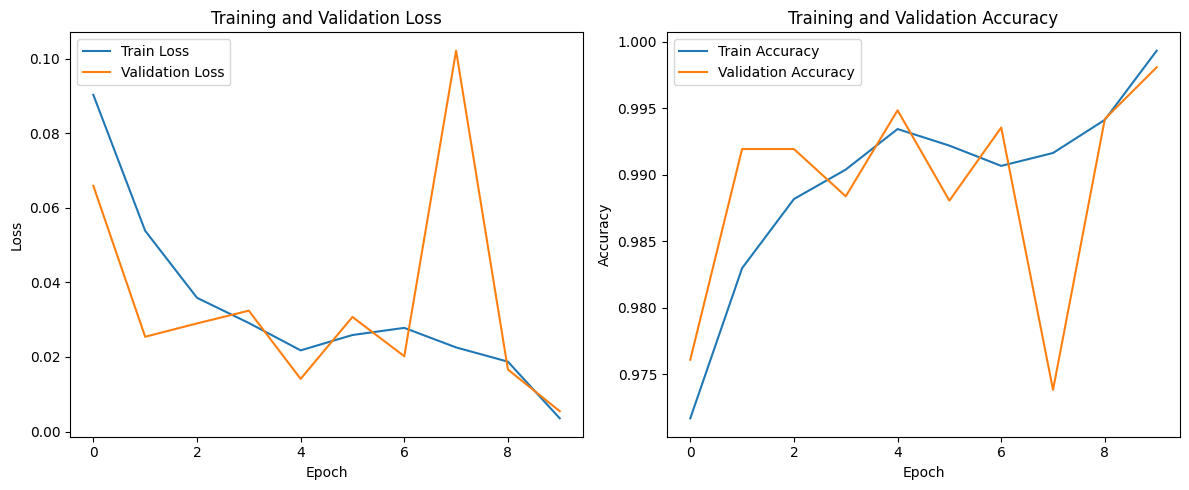

In [23]:
# Train the model
num_epochs = 10
history, best_val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
print(f'Best validation accuracy: {best_val_acc:.4f}')

# Plot training history
plot_training_history(history)


Test Loss: 0.0215
Test Accuracy: 0.9948
Test Precision (macro avg): 0.9937
Test Recall (macro avg): 0.9950
Test F1-Score (macro avg): 0.9943

Per-Class Classification Report:
Pepper__bell___Bacterial_spot: Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Pepper__bell___healthy: Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Potato___Early_blight: Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Potato___Late_blight: Precision: 0.9809, Recall: 0.9872, F1: 0.9840
Potato___healthy: Precision: 0.9706, Recall: 1.0000, F1: 0.9851
Tomato_Bacterial_spot: Precision: 1.0000, Recall: 0.9965, F1: 0.9982
Tomato_Early_blight: Precision: 1.0000, Recall: 0.9787, F1: 0.9892
Tomato_Late_blight: Precision: 0.9866, Recall: 0.9833, F1: 0.9850
Tomato_Leaf_Mold: Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Tomato_Septoria_leaf_spot: Precision: 0.9962, Recall: 1.0000, F1: 0.9981
Tomato_Spider_mites_Two_spotted_spider_mite: Precision: 0.9961, Recall: 0.9883, F1: 0.9922
Tomato__Target_Spot: Precision: 0.9830, Recall:

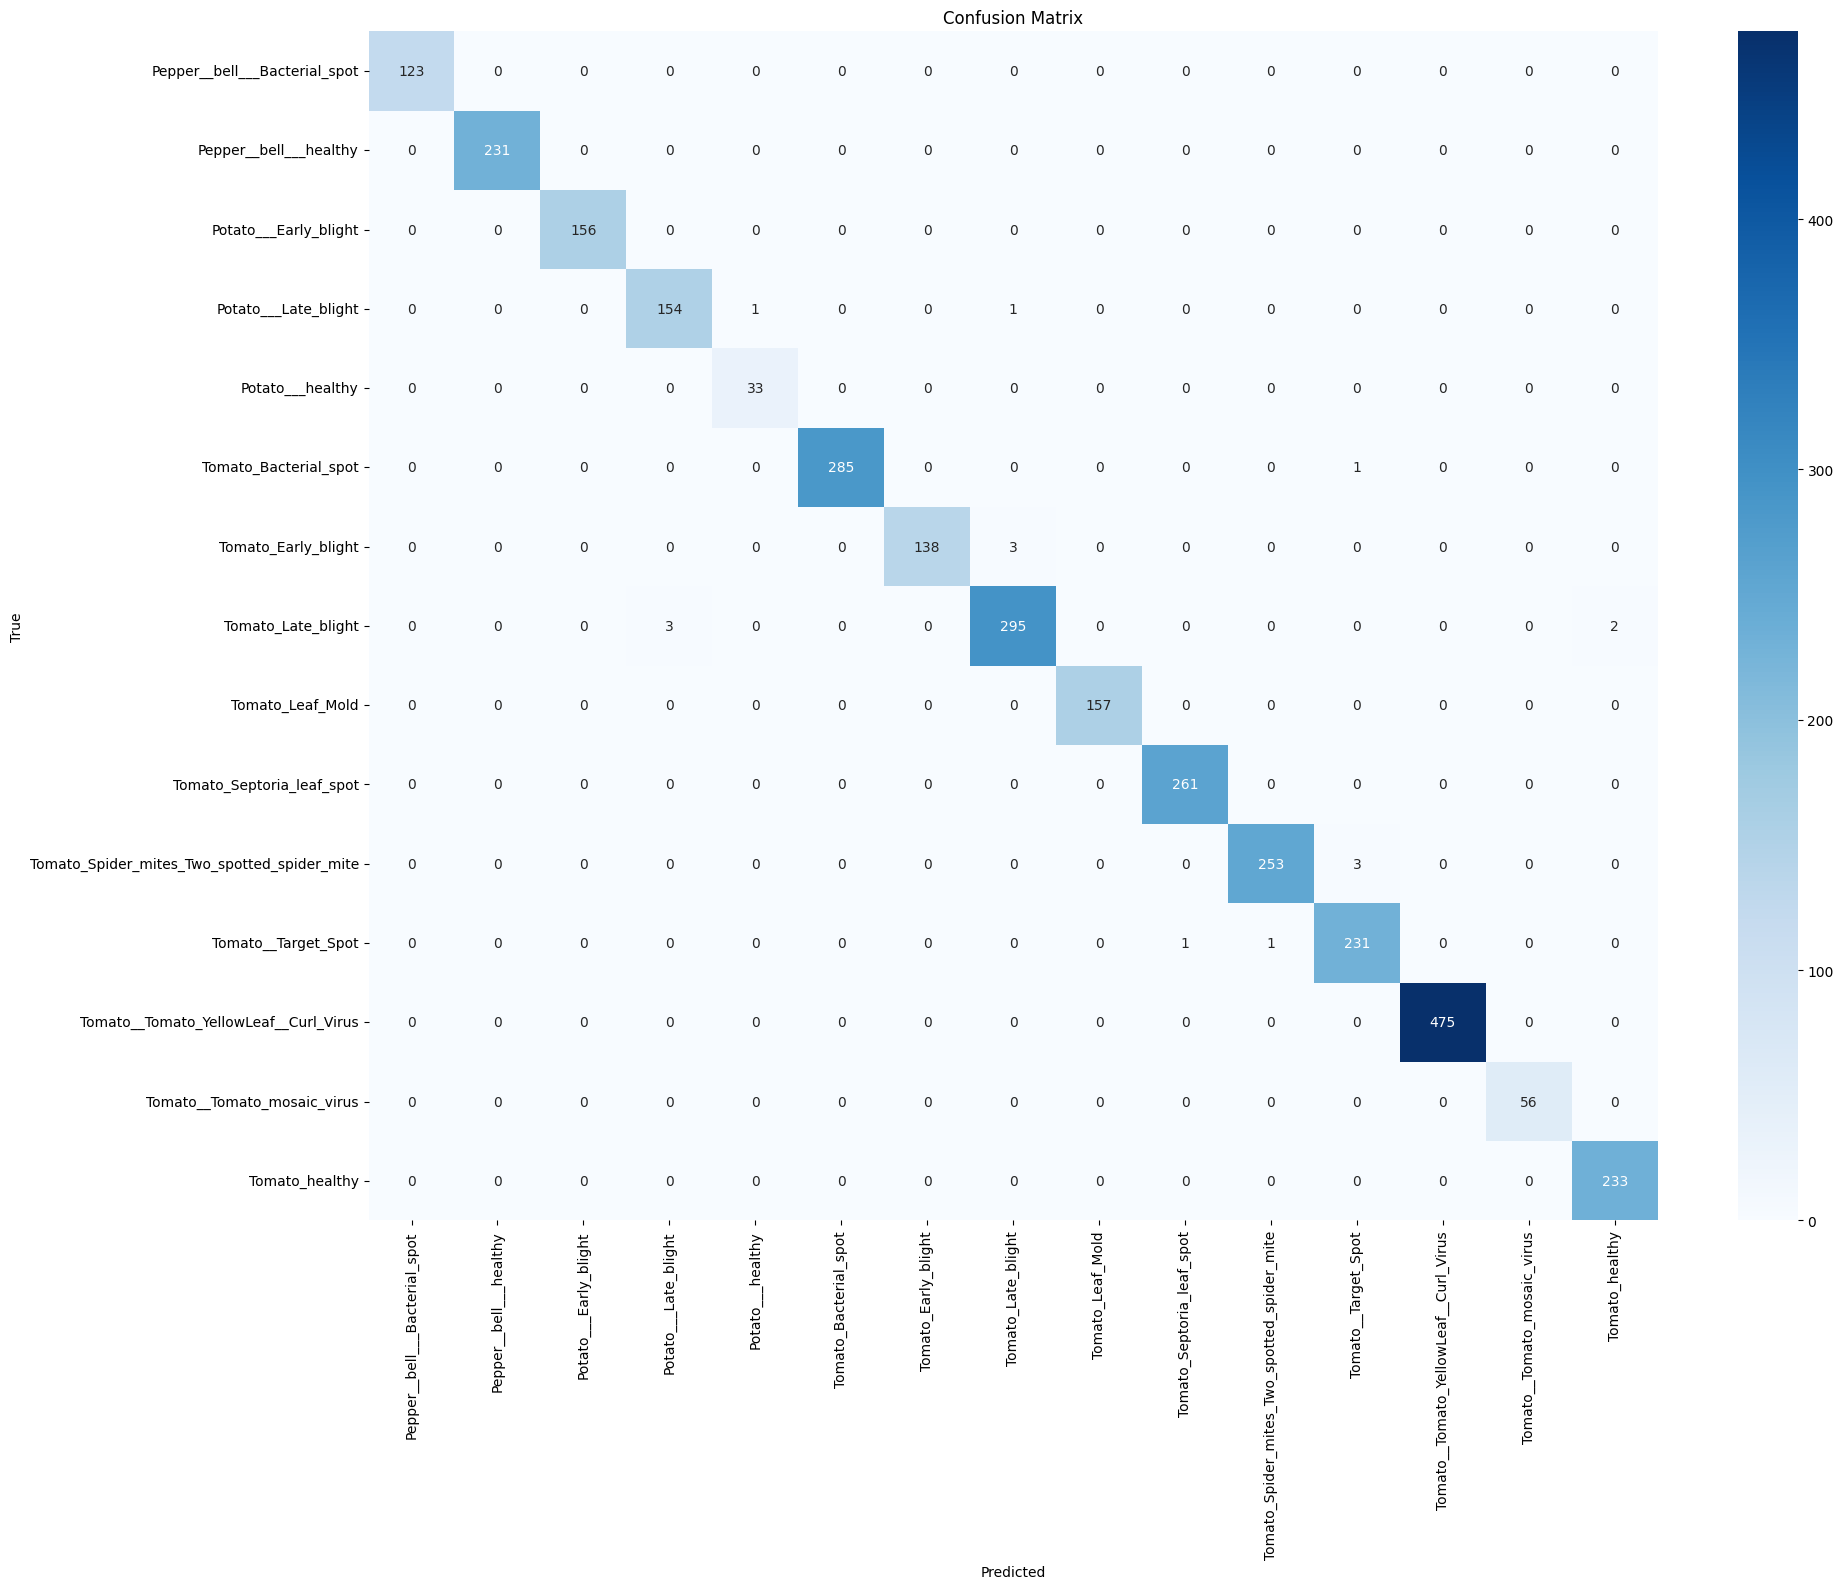

In [47]:
# Load the best model
model.load_state_dict(torch.load(os.path.join(base_dir, 'best_plant_disease_vit.pth')))

# Evaluate on test set
test_loss, test_acc, report, conf_matrix, all_preds, all_labels, precision, recall, f1 = evaluate_model(model, test_loader, criterion)

# Print evaluation results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision (macro avg): {precision:.4f}')
print(f'Test Recall (macro avg): {recall:.4f}')
print(f'Test F1-Score (macro avg): {f1:.4f}')

print('\nPer-Class Classification Report:')
for cls in class_names:
    print(f'{cls}: Precision: {report[cls]["precision"]:.4f}, Recall: {report[cls]["recall"]:.4f}, F1: {report[cls]["f1-score"]:.4f}')

# Plot confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'confusion_matrix.png'), dpi=300)
plt.show()


In [29]:
!pip install tensorflow

In [33]:
!pip install torchviz

In [34]:
# prompt: save and plot all the required graphs and model architechture, to be published in a research paper

import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

# Assuming 'model' and other necessary variables are defined from the previous code

# Function to visualize the model architecture
def visualize_model_architecture(model):
    try:
        from torchviz import make_dot
        dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Adjust input size if necessary
        y = model(dummy_input)
        dot = make_dot(y, params=dict(model.named_parameters()))
        dot.format = 'png'
        dot.render(os.path.join(base_dir, 'model_architecture'), cleanup=True)
        print(f"Model architecture saved to {base_dir}/model_architecture.png")
    except ImportError:
        print("torchviz not found. Install with: !pip install torchviz")


visualize_model_architecture(model)


# Save the plots within the training loop (after each epoch or at the end):

def plot_training_history(history, epoch):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, f'training_history_epoch_{epoch}.png'), dpi=300) #Save each epoch
    plt.show()

# Example usage inside the train_model function
# ... (rest of your train_model code)

        # Save figures for each epoch
    plot_training_history(history, epoch + 1)

# ... (rest of your code)


Model architecture saved to /content//model_architecture.png


In [44]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Create directory for saving metrics
os.makedirs('performance_metrics', exist_ok=True)

def save_all_metrics(model, dataloaders, class_names, history, device, criterion):
    """Save all performance metrics as high-quality figures."""
    # Save training history
    save_training_history(history)

    # Evaluate on test set
    test_loss, test_acc, test_f1, test_precision, test_recall, test_labels, test_preds = evaluate_model(
        model,  dataloaders['test'],criterion)

    # Save confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(14, 12), dpi=300)
    sns.heatmap(
        pd.DataFrame(cm, index=class_names, columns=class_names),
        annot=True, fmt='d', cmap='Blues', linewidths=.5
    )
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('performance_metrics/confusion_matrix.png', bbox_inches='tight')
    plt.close()

    # Save classification report
    report = classification_report(
        test_labels, test_preds,
        target_names=class_names,
        digits=4,
        output_dict=True
    )
    pd.DataFrame(report).transpose().to_csv('performance_metrics/classification_report.csv')

    # Save per-class metrics
    class_metrics = {}
    for cls in class_names:
        class_metrics[cls] = {
            'precision': report[cls]['precision'],
            'recall': report[cls]['recall'],
            'f1-score': report[cls]['f1-score']
        }
    pd.DataFrame(class_metrics).transpose().to_csv('performance_metrics/per_class_metrics.csv')

    # Save ROC curves
    save_roc_curves(model, dataloaders['test'], class_names, device)

def save_training_history(history):
    """Save training history plots."""
    plt.figure(figsize=(12, 6), dpi=300)

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curves', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.savefig('performance_metrics/training_history.png')
    plt.close()

def save_roc_curves(model, test_loader, class_names, device):
    """Plot ROC curves for each class and save the plot."""
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8), dpi=300)
    colors = plt.cm.jet(np.linspace(0, 1, n_classes))  # Distinct colors for each class

    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i], tpr[i], color=color, lw=2,
            label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})'
        )

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves per Class', fontsize=14)
    plt.legend(loc="lower right")
    plt.tight_layout()

    # Ensure the directory exists
    roc_curves_dir = 'performance_metrics/roc_curves'
    os.makedirs(roc_curves_dir, exist_ok=True)

    plt.savefig(os.path.join(roc_curves_dir, 'roc_curves_all.png'), bbox_inches='tight')
    plt.close()

    # Plotting and saving individual ROC curves
    for i in range(n_classes):
        plt.figure(figsize=(8, 6), dpi=300)
        plt.plot(fpr[i], tpr[i], color='blue', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curve for {class_names[i]}', fontsize=14)
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(os.path.join(roc_curves_dir, f'roc_curve_{class_names[i]}.png'), bbox_inches='tight')
        plt.close()


In [45]:
# Assume you have already run training and have the following ready:
# - model: your trained model (with weights loaded if needed)
# - history: dictionary containing 'train_loss', 'val_loss', 'train_acc', 'val_acc'
# - class_names: list of class names in your dataset
# - device: your torch device (e.g., 'cuda' or 'cpu')
# - criterion: your loss function (e.g., nn.CrossEntropyLoss())
# - train_loader, val_loader, test_loader: your DataLoader objects

# Prepare dataloaders dictionary as expected by save_all_metrics
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

# Call the main function to save all metrics and plots
save_all_metrics(
    model=model,
    dataloaders=dataloaders,
    class_names=class_names,
    history=history,
    device=device,
    criterion=criterion
)


ValueError: not enough values to unpack (expected 7, got 6)